In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


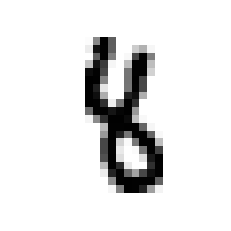

8


In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[7000]
some_data_image = some_digit.reshape(28,28)

plt.imshow(some_data_image, cmap = mpl.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()
print(y[7000])

In [13]:
# y is in the form of a string, converting it to an integer,
import numpy as np
y = y.astype(np.uint8)

# To create a train and a test set,

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# In this exercise, the first 60,000 instances (images) are used for training and the remaining 10,000 for testing.
# The data is already shuffled, which in this case, would ensure that all cross-validation being similar.

In [15]:
# Training a binary classifier,

# Trying instances containing 7 (Note: Binary would verify if an instance would or would not meet the condition)
y_train_7 = (y_train == 7)    # True for all 7s, False for all other instances
y_test_7 = (y_test == 7)

# Picking a classifier and training it,
from sklearn.linear_model import SGDClassifier    # Using the Stichastic Gradient Descent Classifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_7)

# Let's check the classifier by an instance,
sgd_clf.predict([some_digit])

array([False])